In [11]:
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import os
import torch

# Data Processing

In [29]:
# Class to Load images & transcriptions
class TextDataset(Dataset):
    def __init__(self, images_dir, transcriptions_dir, transform=None):
        self.images_dir = images_dir
        self.transcriptions_dir = transcriptions_dir
        self.transform = transform
        self.image_filenames = os.listdir(images_dir)

    def parse_transcrpition(self, transcription_file):
        bounding_boxes = []
        texts = []

        with open(transcription_file, 'r') as file:
            for line in file:
                parts = line.strip().split(',')
                coords = list(map(int, parts[:8]))
                text = parts[8]
                bounding_boxes.append(coords)
                texts.append(text)
            
        return bounding_boxes, texts
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, index):
        image_name = self.image_filenames[index]
        image_path = os.path.join(self.images_dir, image_name)
        transcription_file_name = f"gt_{image_name.replace('.jpg', '.txt')}"
        transcription_path = os.path.join(self.transcriptions_dir, transcription_file_name)
        image = Image.open(image_path).convert("RGB")
        bounding_boxes, texts = self.parse_transcrpition(transcription_path)

        if self.transform:
            image = self.transform(image)

        return image, bounding_boxes, texts
        

In [30]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = TextDataset(images_dir="./dataset/test/test_images/", transcriptions_dir="./dataset/test/test_localization_transcription/")
data_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

In [31]:
def visualize_bounding_boxes(image_path, bounding_boxes, texts):
    image = cv2.imread(image_path)

    for box, text in zip(bounding_boxes, texts):
        points = np.array([[box[i], box[i + 1]] for i in range(0, 8, 2)], np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.polylines(image, [points], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.putText(image, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 0, 0), 1)

    cv2.imshow("Image with bounding Boxes", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [39]:
image_path = "./dataset/test/test_images/img_10.jpg"
bounding_boxes, texts = dataset.parse_transcrpition('./dataset/test/test_localization_transcription/gt_img_10.txt')
visualize_bounding_boxes( image_path, bounding_boxes, texts)

# Analyticals of Dataset

In [25]:
def calculate_statistics(dataset):
    num_bboxes = []
    text_lengths = []
 
    for _, bounding_boxes, texts in dataset:
        num_bboxes.append(len(bounding_boxes))
        text_lengths.extend([len(text) for text in texts])
 
    return num_bboxes, text_lengths

In [26]:
def plot_histogram(data, title, xlabel, ylabel):
    plt.hist(data, bins=20, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [27]:
# Function for correlation analysis
def plot_correlation_matrix(num_bboxes, text_lengths, box_areas):
    data = np.array([num_bboxes, text_lengths, box_areas])
    corr_matrix = np.corrcoef(data)
   
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
                xticklabels=['Num Bboxes', 'Text Lengths', 'Box Areas'],
                yticklabels=['Num Bboxes', 'Text Lengths', 'Box Areas'])
    plt.title('Correlation Matrix')
    plt.show()

In [33]:
num_bboxes, text_lengths = calculate_statistics(dataset)

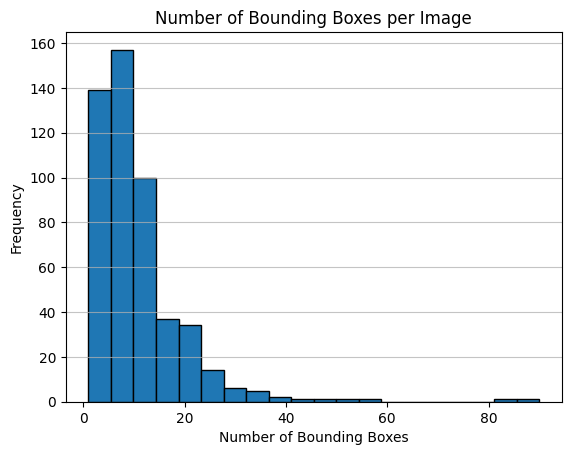

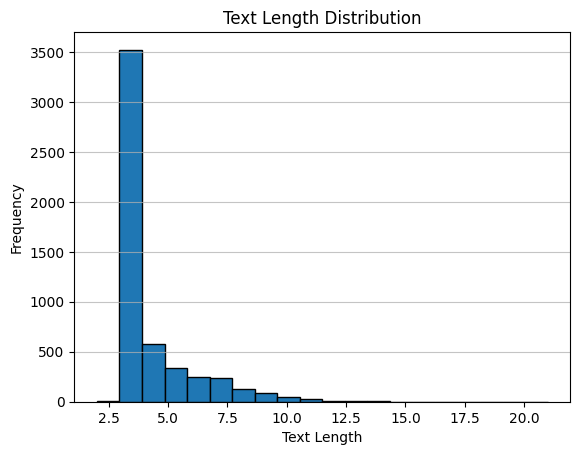

In [34]:
# Plot statistics
plot_histogram(num_bboxes, 'Number of Bounding Boxes per Image', 'Number of Bounding Boxes', 'Frequency')
plot_histogram(text_lengths, 'Text Length Distribution', 'Text Length', 'Frequency')
 

In [36]:
print(f"Total number of images: {len(dataset)}")
print(f"Total bounding boxes: {sum(num_bboxes)}")
print(f"Average number of bounding boxes per image: {np.mean(num_bboxes):.2f}")
print(f"Average text length: {np.mean(text_lengths):.2f}")

Total number of images: 500
Total bounding boxes: 5230
Average number of bounding boxes per image: 10.46
Average text length: 3.93


In [37]:
# Function to format and display the detected text
def display_detected_text(dataset):
    print(f"{'=' * 50}")
    print(f"{'Detected Text from Dataset':^50}")
    print(f"{'=' * 50}\n")

    for index in range(len(dataset)):
        _, _, texts = dataset[index]
        image_name = dataset.image_filenames[index]
        
        print(f"Image: {image_name}")
        print(f"{'-' * 50}")
        
        if texts:
            for i, text in enumerate(texts, start=1):
                print(f"Text {i}: {text}")
        else:
            print("No text detected.")
        
        print(f"{'=' * 50}\n")

In [38]:
# Display all detected text
display_detected_text(dataset)

            Detected Text from Dataset            

Image: img_1.jpg
--------------------------------------------------
Text 1: ###
Text 2: ###
Text 3: ###
Text 4: ###
Text 5: ###
Text 6: ###
Text 7: ###
Text 8: ###

Image: img_10.jpg
--------------------------------------------------
Text 1: Please
Text 2: lower
Text 3: your
Text 4: volume
Text 5: when
Text 6: you
Text 7: pass
Text 8: ###
Text 9: residential
Text 10: areas

Image: img_100.jpg
--------------------------------------------------
Text 1: ###
Text 2: diverse
Text 3: tastes
Text 4: ###
Text 5: flavours
Text 6: the
Text 7: Refishing
Text 8: DINING
Text 9: ###
Text 10: ###
Text 11: DINING
Text 12: ###

Image: img_101.jpg
--------------------------------------------------
Text 1: SALE
Text 2: MARC
Text 3: ###

Image: img_102.jpg
--------------------------------------------------
Text 1: ST.MARC
Text 2: CAFE
Text 3: ###
Text 4: ###

Image: img_103.jpg
--------------------------------------------------
Text 1: ###
Text 2: ###
Te